# 뉴스기사 요약하기

## 1. 데이터 수집
## 2. 추상적 요약
### 2.1. 데이터 전처리
### 2.2. 어텐션 메커니즘 사용한 모델 설계
### 2.3. 실제 결과와 요약문 비교하기
## 3. Summa를 이용한 추출적 요약

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('라이브러리 준비 완료!')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


라이브러리 준비 완료!


## 1. 데이터 수집

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('전체 샘플수 :', (len(data)))
data.sample(10)


전체 샘플수 : 98401


,headlines,text
13039,"Aus spinner has not overstepped for over 20,00...",Australian spinner Nathan Lyon has not overste...
2838,South Korean startup makes Ã¢ÂÂ¹1.2L smart tr...,South Korean startup The Little Cat showed its...
9946,"Isha Ambani, Anand to live in Ã¢ÂÂ¹450 cr sea...",Mukesh Ambani's daughter Isha Ambani and her h...
50726,Uber CEO Dara Khosrowshahi to visit India next...,Uber's Chief Executive Officer Dara Khosrowsha...
78255,"Taapsee, Rishi to be seen together in upcoming...",Actors Taapsee Pannu and Rishi Kapoor will be ...
55385,Tesla rival Faraday Future raises $1 billion: ...,Electric carmaker and Tesla rival Faraday Futu...
74736,A 'dead star' may be a leftover of stellar exp...,"Astronomers have identified a white dwarf, fue..."
59839,Pak court orders release of 26/11 mastermind H...,A Pakistani court on Wednesday ordered the rel...
93126,Facebook shuts man's account for uploading liv...,Social media platform Facebook has shut down a...
7075,Surrendered militant among 3 held with heroin ...,"Three suspected drug smugglers, including a su..."


## 2. 추상적 요약
### 2.1. 데이터 전처리

- 결측치, 중복 값 제거
- 텍스트 정규화
- 불용어 제거 
- 샘플의 최대 길이 정하기
- 시작토큰, 종료 토큰 추가
- 훈련 데이터와 테스트 데이터 분리
- 훈련 데이터로 단어집합(vocabulary) 만들기
- 정수 인코딩
- 패딩


#### 결측치, 중복값 제거

In [3]:
# 컬럼별 중복치 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [4]:
# 중복값 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [5]:
# 결측치 확인
print(data.isnull().sum())


headlines    0
text         0
dtype: int64


#### 텍스트 정규화 및 불용어 처리

In [6]:
# 정규화 사전 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
# 데이터 전처리, 불용어 제거

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [9]:
# data['text'] 전처리
clean_text = []

for c in data['text']:
    clean_text.append(preprocess_sentence(c, remove_stopwords=True))



In [10]:
# data['headlines'] 전처리
clean_summary = []

for c in data['headlines']:
    clean_summary.append(preprocess_sentence(c, remove_stopwords=True))


In [11]:
# 데이터프레임에 반영
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [12]:
# 전처리 결과 출력
print("Text 전처리 후 결과: ", clean_text[:5])
print("Summary 전처리 후 결과: ", clean_summary[:5])
print("결측치 확인:", data.isnull().sum())

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 샘플의 최대 길이 정하기


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136183407889386


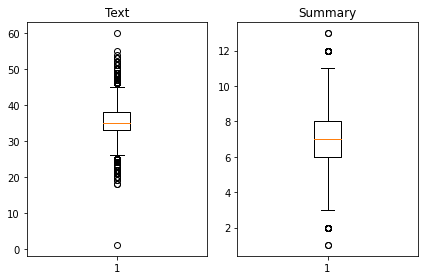

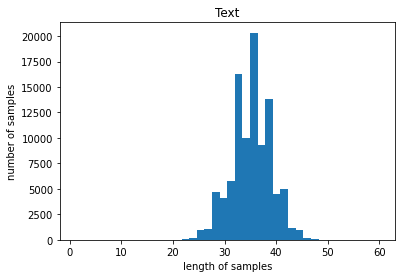

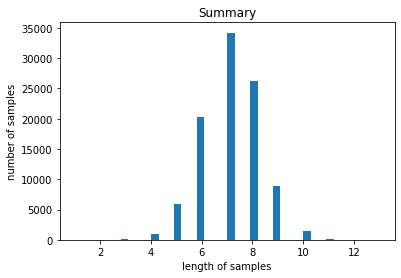

In [14]:
# 길이 분포 시각화
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# text, summary의 적절한 최대길이 임의 설정
text_max_len = 50
summary_max_len = 10

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9978344855632371


In [18]:
# 임의의 길이보다 큰 샘플 제외
data = data[(data['text'].apply(lambda x: len(x.split())) <= text_max_len) & 
            (data['headlines'].apply(lambda x: len(x.split())) <= summary_max_len)]


In [19]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98134


#### 시작토큰, 종료 토큰 추가


In [20]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [22]:
# 인코더 디코더 입력을 numpy 타입으로 변경
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [28]:
data.to_csv('complete_preprocessing.csv', index=False)

#### 훈련 데이터와 테스트 데이터 분리


In [23]:
# 데이터 분리
## 1. input과 크기 같은 정수 시퀸스 생성
indices = np.arange(encoder_input.shape[0]) #input과 크기 같은 정수 시퀸스
np.random.shuffle(indices) # 시퀸스 랜덤화
print(indices)

[46398 56638 35440 ... 96712 19908 63849]


In [24]:
## 데이터 샘플 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [25]:
# 훈련 데이터와 테스트 데이터 분리 크기 설정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19626


In [26]:
# 데이터 분할
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78508
훈련 레이블의 개수 : 78508
테스트 데이터의 개수 : 19626
테스트 레이블의 개수 : 19626


#### 훈련 데이터로 단어집합(vocabulary) 만들기

- 모델 훈련을 위해 텍스트 데이터를 정수형태로 바꾸는 작업 필요
- 각각의 단어에 고유한 정수를 맵핑해서 단어 집합 생성

#### text

In [29]:
# 토크나이저: 텍스트 데이터를 토큰으로 분리
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # src_tokenizer.word_index: 단어와 인덱스 쌍의 매핑 개수 출력
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items(): # 단어와 해당 단어의 등장 횟수 사이의 매핑 관계를 제공하는 딕셔너리
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 즉 빈도가 threshold 이하인 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69332
등장 빈도가 6번 이하인 희귀 단어의 수: 47264
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22068
단어 집합에서 희귀 단어의 비율 즉 빈도가 threshold 이하인 단어의 비율: 68.17054174118734
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4940137780026763


전체 단어 집합에서 빈도가 threshold 이하인 단어들은 68% 그러나 이러한 단어들이 실제 훈련 데이터에서 등장 빈도로 차지하는 비중은 3.5%이다.
따라서 등장 빈도가 threshold회 이하인 단어들은 정수 인코딩 과정에서 빼고 훈련 데이터에서 제거한다.

In [31]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2, 42, 3556, 956, 4154, 6391, 1586, 557, 1, 2, 1067, 4204, 948, 1426, 522, 2, 492, 19405, 4204, 4154, 761, 104, 321, 15355, 726, 9119, 447, 1533, 956, 7, 895, 718, 1515, 58], [79, 2724, 5858, 1, 1460, 1479, 10476, 24, 4, 9120, 943, 136, 57, 1769, 926, 500, 2323, 283, 18374, 2724, 1, 210, 40, 6974, 1460], [2, 6715, 1563, 9816, 3769, 3587, 265, 7, 26, 512, 1903, 551, 11002, 18375, 3455, 285, 177, 4917, 235, 347, 1776, 87, 1156, 26, 177, 265, 1903, 551]]


#### headlines

In [33]:
# headlines 에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29799
등장 빈도가 5번 이하인 희귀 단어의 수: 19512
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10287
단어 집합에서 희귀 단어의 비율: 65.47870733917246
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.857357733767862


In [35]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3, 1219, 769, 8642, 5073, 2165, 2209], [1, 1824, 5074, 2428, 61, 53, 1991], [1, 3, 56, 979, 6337, 4873, 2339, 1716, 17, 27, 150], [1, 8049, 7035, 648, 385, 2524, 888], [1, 120, 86, 8050, 187, 125, 1969, 1802]]
target
decoder  [[3, 1219, 769, 8642, 5073, 2165, 2209, 2], [1824, 5074, 2428, 61, 53, 1991, 2], [3, 56, 979, 6337, 4873, 2339, 1716, 17, 27, 150, 2], [8049, 7035, 648, 385, 2524, 888, 2], [120, 86, 8050, 187, 125, 1969, 1802, 2]]


빈도수가 낮은 단어들을 제외하였으므로, 빈도수가 낮은 단어들만으로 구성되었던 샘플들이 빈 샌플이 되었을 수도 있다. 특히 healines가 더더욱 그렇다

따라서 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장

In [36]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 78507
훈련 레이블의 개수 : 78507
테스트 데이터의 개수 : 19623
테스트 레이블의 개수 : 19623


#### 패딩

In [37]:
# 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩작업 수행
## 아까 정해주었던 최대 길이로 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


### 2.2. 어텐션 메커니즘 사용한 모델 설계

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [42]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [43]:
# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 40s 106ms/step - loss: 5.5880 - val_loss: 5.1515
Epoch 2/50
307/307 [==============================] - 31s 100ms/step - loss: 5.0269 - val_loss: 4.7935
Epoch 3/50
307/307 [==============================] - 31s 100ms/step - loss: 4.7159 - val_loss: 4.5638
Epoch 4/50
307/307 [==============================] - 31s 100ms/step - loss: 4.4657 - val_loss: 4.3845
Epoch 5/50
307/307 [==============================] - 31s 100ms/step - loss: 4.2631 - val_loss: 4.2477
Epoch 6/50
307/307 [==============================] - 31s 100ms/step - loss: 4.0937 - val_loss: 4.1454
Epoch 7/50
307/307 [==============================] - 31s 100ms/step - loss: 3.9472 - val_loss: 4.0685
Epoch 8/50
307/307 [==============================] - 31s 100ms/step - loss: 3.8174 - val_loss: 4.0003
Epoch 9/50
307/307 [==============================] - 31s 100ms/step - loss: 3.7006 - val_loss: 3.9509
Epoch 10/50
307/307 [==============================] - 31s 100ms/step - l

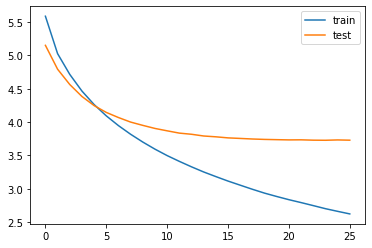

In [44]:
# 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 모델 테스트
seq2seq 모델은 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 모델 설계를 별개로 진행해야 함


In [45]:
# 3개 사전 미리 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [47]:
# 어텐션 메커니즘 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [48]:
# 인퍼런스 단계에서 단어 시퀸스 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former pakistani president pervez musharraf thursday said hoped pakistan tehreek insaf chairman imran khan govern pakistan better way imran khan problem areas honest man wants good good qualities added musharraf barred pakistan supreme court contesting elections 
실제 요약 : hope imran pakistan better way ex prez musharraf 
예측 요약 :  imran khan pak ties imran khan


원문 : researchers discovered potato year old stone tool utah giving earliest evidence wild potato use north america researchers working mine dna genes resistant drought disease however potatoes eat today come single species south american years ago researchers said 
실제 요약 : oldest potato remains us found year old stone 
예측 요약 :  scientists discover human dna


원문 : wicketkeeper batsman jos buttler shared video england cricket team celebrating country fifa world cup round shootout victory colombia tuesday players watched match old trafford dressing room lost first india heard singing coming home referring england world cup tr

예측 요약 :  india best world cup win yuvraj


원문 : hrd minister prakash javadekar informed parliament new central universities functioning vacant posts whereas iits teacher vacancies respectively javadekar revealed government plans invite industry experts fill teaching vacancies aims fill least vacant posts end 
실제 요약 : posts vacant new central universities iits 
예측 요약 :  govt plans reduce varsity varsity varsity varsity


원문 : windies world cup winning captain darren sammy become father baby boy rounder revealed twitter saturday sammy posted picture new born captioned reign sammy king born today mummy also well giving thanks high blessings 
실제 요약 : former windies captain becomes father baby boy 
예측 요약 :  world cup baby mom mom mom


원문 : chhattisgarh cm raman singh friday asserted final battle maoists fought state anti naxal operations continue bastar state government rest till peaceful development bastar added notably naxal ambush crpf patrol party last week led martyrdom soldiers 
실제 요

예측 요약 :  miss world manushi manushi miss world manushi


원문 : mit researchers developed shape shifting robots controlled via magnets make walk roll sail glide device carries actions wearing origami made sheets plastic fold specific shapes heated finishing task shed skin water 
실제 요약 : robot shifts skeleton walk roll sail 
예측 요약 :  mit develops robot robot drugs




## 3. Summa를 이용한 추출적 요약

In [52]:
import requests
from summa.summarizer import summarize

In [53]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [54]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [55]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [56]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [57]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
